In [1]:
## Evalutate the effect of Zero phase in network inversion
## Test data: SenDT128

import os
import numpy as np
from matplotlib import ticker, pyplot as plt
from pysar.objects import timeseries, ifgramStack, geometry, sensor
from pysar.utils import plot as pp, network as pnet, ptime
from pysar.simulation import simulation as sim
from pysar.simulation.plot import *
from pysar import ifgram_inversion as ifginv


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase'
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
os.chdir(work_dir)
print('Go to directory: '+work_dir)

ref_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR'
ref_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR'
pts_yx = [290, 415]
sensorName = sensor.project_name2sensor(ref_dir)[0]

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase


In [23]:
ref_ts_file = os.path.join(ref_dir, 'timeseries.h5')
ts_obj = timeseries(ref_ts_file)
ts_obj.open()
date_list = ts_obj.get_date_list()
pbase_list = ts_obj.pbase.tolist()
tbase_list = ts_obj.tbase.tolist()
dates = ptime.date_list2vector(date_list)[0]

with open('bl_list.txt', 'w') as f:
    print('writing >>> bl_list.txt')
    for d, pbase in zip(ptime.yymmdd(date_list), pbase_list):
        f.write('{}\t{}\n'.format(d, pbase))

## 1. Linear velocity to timeseries
TS_TXT_FILE = 'timeseries'
ts_sim = sim.velocity2timeseries(date_list, vel=0.03, display=False)
np.save(TS_TXT_FILE, np.hstack((np.array(date_list).reshape(-1,1), ts_sim.reshape(-1,1))))
print('save range change time series to file.')

display = False
if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.scatter(tbase_list, ts_sim*100.0, s=marker_size**2)
    ax.set_xlabel('Time (days)', fontsize=font_size)
    ax.set_ylabel('Displacement (cm)', fontsize=font_size)
    #ax.set_xlim([-200,2900])
    ax.tick_params(direction='in', labelsize=font_size)
    plt.savefig('SimTimeseriesLin'+fig_ext, bbox_inches='tight', dpi=fig_dpi)
    #plt.title('Displacement time series')
    #plt.show()
    
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.plot(tbase_list, pbase_list, '-ko', alpha=0.8, lw=1, ms=marker_size, mfc='orange')
    ax = pp.auto_adjust_yaxis(ax, pbase_list, font_size)
    ax.set_xlabel('Time (days)',fontsize=font_size)
    ax.set_ylabel('Perpendicular Baseline (m)',fontsize=font_size)
    #ax.set_xlim([-200,2900])
    ax.tick_params(direction='in', labelsize=font_size)
    plt.savefig('BaselineHistory'+fig_ext, bbox_inches='tight', dpi=fig_dpi)
    plt.show()

# Read coherence/date12_list from reference file
stack_obj = ifgramStack(os.path.join(ref_dir, 'INPUTS/ifgramStack.h5'))
stack_obj.open()
geom_obj = geometry(os.path.join(ref_dir, 'INPUTS/geometryRadar.h5'))
inc_angle = np.nanmean(geom_obj.read(datasetName='incidenceAngle'))

date12_list = stack_obj.date12List                # use pairs from data file
date12_list = pnet.select_pairs_all(date_list)    # use all pairs for demonstration
date12_list = ptime.yyyymmdd_date12(date12_list)

box = (pts_yx[1], pts_yx[0], pts_yx[1]+1, pts_yx[0]+1)
coh = stack_obj.read(datasetName='coherence', box=box)

coh = pnet.simulate_coherence(date12_list,
                              baseline_file='bl_list.txt',
                              sensor_name=sensorName,
                              inc_angle=inc_angle,
                              decor_time=200.0,
                              coh_resid=0.2)

# Simulate coherence/date12_list

if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax = pp.plot_coherence_matrix(ax, date12_list, coh.tolist())
    plt.show()

print('simulate unwrapped phase')
wvl = sensor.wavelength('Sen')
range2phase = -4.0 * np.pi / wvl
ifgram_sim = sim.timeseries2ifgram(ts_sim, date_list, date12_list, wvl=wvl, display=display)

print('simulate decorrelation noise')
L = int(stack_obj.metadata['ALOOKS']) * int(stack_obj.metadata['RLOOKS'])
decor_noise_file = 'decor_noise.npy'
re_generate_noise = True
if re_generate_noise or not os.path.isfile(decor_noise_file):
    decor_sim = sim.simulate_decorrelation_noises(date12_list, coh, L=L, display=display)
    np.save(decor_noise_file, decor_sim)
else:
    decor_sim = np.load(decor_noise_file)
print('Done.')

open timeseries file: timeseries.h5
writing >>> bl_list.txt
save range change time series to file.
open ifgramStack file: ifgramStack.h5
reading incidenceAngle data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/geometryRadar.h5 ...
reading coherence data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/ifgramStack.h5 ...
simulate unwrapped phase
simulate decorrelation noise
Done.


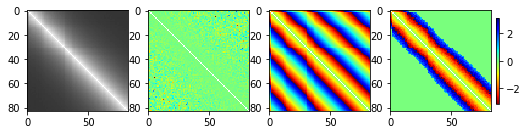

In [30]:
# plot ifgram simulation process
ifgram_comb = ifgram_sim + decor_sim

min_coh = 0.4
if min_coh != 0.:
    ifgram_comb[coh<min_coh] = 0.
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=[8, 3])

data_mat = pnet.coherence_matrix(date12_list, coh)
ax1.imshow(data_mat, cmap='gray', vmin=0, vmax=1)

wrap = True
for ax, data in zip([ax2, ax3, ax4],
                    [decor_sim, ifgram_sim, ifgram_comb]):
    data_mat = pnet.coherence_matrix(date12_list, data)
    data_mat -= np.round(data_mat/(2*np.pi)) * (2*np.pi)
    im = ax.imshow(data_mat, cmap='jet_r', vmin=-np.pi, vmax=np.pi)
fig.subplots_adjust(right=0.93)
cax = fig.add_axes([0.94, 0.3, 0.005, 0.4])
cbar = plt.colorbar(im, cax=cax)
cbar.locator = ticker.MaxNLocator(nbins=4)
cbar.update_ticks()
plt.savefig('ifgram_sim.png', bbox_inches='tight', dpi=fig_dpi)
plt.show()

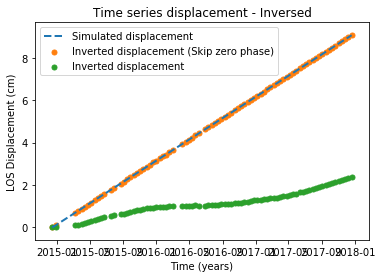

In [28]:
## Invert network of ifgrams into time-series
A, B = stack_obj.get_design_matrix(date12_list=date12_list)
weight = ifginv.coherence2fisher_info_index(coh, L)
ts_inv = ifginv.network_inversion_wls(A, ifgram_comb, weight, skip_zero_phase=True)[0]
ts_inv = np.vstack((0, ts_inv)) / range2phase

ts_inv_skip = ifginv.network_inversion_wls(A, ifgram_comb, weight, skip_zero_phase=False)[0]
ts_inv_skip = np.vstack((0, ts_inv_skip)) / range2phase

plt.figure()
plt.plot(dates, list(ts_sim*100.0),
         '--', lw=2, label='Simulated displacement', color=pp.mplColors[0])
plt.scatter(dates, list(ts_inv*100.0),
            s=marker_size**2, label='Inverted displacement (Skip zero phase)', color=pp.mplColors[1])
plt.scatter(dates, list(ts_inv_skip*100.0),
            s=marker_size**2, label='Inverted displacement', color=pp.mplColors[2])
ax = pp.auto_adjust_xaxis_date(ax, datevector, fontSize=12, every_year=1):
plt.xlabel('Time (years)')
plt.ylabel('LOS Displacement (cm)')
plt.title('Time series displacement - Inversed')
plt.legend()
plt.savefig('NetworkInv_simulation.png', bbox_inches='tight', dpi=fig_dpi)
plt.show()